In [1]:
from numpy import array
from numpy import asarray
from numpy import zeros
import spacy
import json
from keras.utils import np_utils 
from keras.layers import LSTM, Bidirectional
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import keras.layers

In [4]:
from keras.models import *
import numpy as np
import pandas as pd
from keras import layers, models, optimizers
from keras import backend as K

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Define the Important settings and Variables
HIDDEN_DIM = 20
MAX_SEQ_LEN = 1000
NR_CLASS = 2
NR_HIDDEN = 16

In [7]:
from utils import *

In [8]:
def read_data_set(file = "_train_NN_15k_sample.json"):
    with open(file) as train_file:
        dev = json.load(train_file)
    claims = []
    evidences = []
    labels = []
    
    for key,item in dev.items():
        claims.append(item["claim"])
        evidences.append(item["evidence"])
        labels.append(item["label"])
    return claims, evidences, np.asarray(labels)

In [9]:
claims, evidences, labels = read_data_set()

In [10]:
# define documents
docs = claims + evidences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
print("Total Vocab Size: ",vocab_size)
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of 4 words
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQ_LEN, padding='post')

Total Vocab Size:  28653


In [11]:
[padded_docs[:len(docs)] ,padded_docs[len(docs):]]

[array([[2852, 2138,   10, ...,    0,    0,    0],
        [1861,  306,   10, ...,    0,    0,    0],
        [3682,  612,   14, ...,    0,    0,    0],
        ...,
        [ 559, 1494, 1724, ...,    0,    0,    0],
        [   1,  386,  250, ...,    0,    0,    0],
        [  21,   44,   57, ...,    0,    0,    0]], dtype=int32),
 array([], shape=(0, 1000), dtype=int32)]

In [12]:
def get_embeddings(vocab, nr_unk=100):
    # the extra +1 is for a zero vector representing sentence-final padding
    num_vectors = max(lex.rank for lex in vocab) + 2 
    
    # create random vectors for OOV tokens
    oov = np.random.normal(size=(nr_unk, vocab.vectors_length))
    oov = oov / oov.sum(axis=1, keepdims=True)
    
    vectors = np.zeros((num_vectors + nr_unk, vocab.vectors_length), dtype='float32')
    vectors[1:(nr_unk + 1), ] = oov
    for lex in vocab:
        if lex.has_vector and lex.vector_norm > 0:
            vectors[nr_unk + lex.rank + 1] = lex.vector / lex.vector_norm 

    return vectors

In [13]:
def create_embedding(vectors, max_length, projected_dim):
    return models.Sequential(
        [
            layers.Embedding(
                vectors.shape[0],
                vectors.shape[1],
                input_length=max_length,
                weights=[vectors],
                trainable=False,
            ),
            layers.TimeDistributed(
                layers.Dense(projected_dim, activation=None, bias=False)
            ),
        ]
    )

In [14]:
def build_model(vectors, shape, settings):
    max_length, nr_hidden, nr_class = shape

    input1 = layers.Input(shape=(max_length,), dtype="int32", name="claim")
    input2 = layers.Input(shape=(max_length,), dtype="int32", name="evidence")

    # embeddings (projected)
    embed = create_embedding(vectors, max_length, nr_hidden)

    a = embed(input1)
    b = embed(input2)

    # step 1: attend
    F = create_feedforward(nr_hidden)
    #F = Bidirectional(LSTM(nr_hidden, return_sequences=True, dropout=0.2))
    att_weights = layers.dot([F(a), F(b)], axes=-1)

    G = create_feedforward(nr_hidden)

    norm_weights_a = layers.Lambda(normalizer(1))(att_weights)
    norm_weights_b = layers.Lambda(normalizer(2))(att_weights)
    alpha = layers.dot([norm_weights_a, a], axes=1)
    beta = layers.dot([norm_weights_b, b], axes=1)

    # step 2: compare
    comp1 = layers.concatenate([a, beta])
    comp2 = layers.concatenate([b, alpha])
    print(comp1.shape,comp2.shape)
    

    feed_forward2 = models.Sequential(
                        [
                            layers.Dense(output_dim=8, activation="relu",input_dim=32),
                            layers.Dropout(0.1),
                            layers.Dense(output_dim=8, activation="relu"),
                            layers.Dropout(0.1),
                        ],name="FeedForward Layer2")
        
    #v1 = layers.TimeDistributed(Dense(output_dim=8))(comp1)
    #v2 = layers.TimeDistributed(Dense(output_dim=8))(comp2)
    v1 = layers.TimeDistributed(feed_forward2)(comp1)
    v2 = layers.TimeDistributed(feed_forward2)(comp2)

    # step 3: aggregate
    v1_sum = layers.Lambda(sum_word)(v1)
    v2_sum = layers.Lambda(sum_word)(v2)
    concat = layers.concatenate([v1_sum, v2_sum])


    H = create_feedforward(nr_hidden)
    out = H(concat)
    out = layers.Dense(nr_class, activation="softmax")(out)

    model = Model([input1, input2], out)

    model.compile(
        optimizer=optimizers.Adam(lr=settings["lr"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [15]:
nlp = spacy.load("en_vectors_web_lg")

In [16]:
def create_dataset(nlp, texts, hypotheses, num_unk, max_length):
    sents = texts + hypotheses
    sents_as_ids = []
    for sent in sents:
        doc = nlp(sent)
        word_ids = []
        for i, token in enumerate(doc):
            # skip odd spaces from tokenizer
            if token.has_vector and token.vector_norm == 0:
                continue

            if i > max_length:
                break

            if token.has_vector:
                word_ids.append(token.rank + num_unk + 1)
            else:
                # if we don't have a vector, pick an OOV entry
                word_ids.append(token.rank % num_unk + 1)

        # there must be a simpler way of generating padded arrays from lists...
        word_id_vec = np.zeros((max_length), dtype="int")
        clipped_len = min(max_length, len(word_ids))
        word_id_vec[:clipped_len] = word_ids[:clipped_len]
        sents_as_ids.append(word_id_vec)

    return [np.array(sents_as_ids[: len(texts)]), np.array(sents_as_ids[len(texts) :])]


In [17]:
def create_feedforward(num_units=200, activation="relu", dropout_rate=0.2):
    return models.Sequential(
        [
            layers.Dense(num_units, activation=activation,input_dim=NR_HIDDEN),
            layers.Dropout(dropout_rate),
            layers.Dense(num_units, activation=activation),
            layers.Dropout(dropout_rate),
        ]
    )


def normalizer(axis):
    def _normalize(att_weights):
        exp_weights = K.exp(att_weights)
        sum_weights = K.sum(exp_weights, axis=axis, keepdims=True)
        return exp_weights / sum_weights

    return _normalize


def sum_word(x):
    return K.sum(x, axis=1)

In [18]:
# Bulding the Model

In [39]:
import random

In [19]:
# max_length, nr_hidden, nr_class is the shape
train_claims, train_evidence, train_labels = read_data_set()
shape = (MAX_SEQ_LEN, NR_HIDDEN, 2)
settings = {"lr": 0.001, "dropout": 0.2, "gru_encode": False}

In [20]:
train_X = create_dataset(nlp, train_claims, train_evidence,100,shape[0])

In [21]:
model = build_model(get_embeddings(nlp.vocab), shape, settings)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 1000, 32) (?, 1000, 32)


In [22]:
LABELS = []
for item in train_labels:
    if item == "SUPPORTS":
        LABELS.append(1)
    else:
        LABELS.append(0)

In [23]:
%%time
train_labels = to_categorical(np.array(LABELS), num_classes=2)
# call back for early stopping 
es = [EarlyStopping(monitor='val_loss',verbose=1,mode='min',patience=2)]
r = model.fit(
    train_X,
    train_labels,
    validation_split=0.2,
    batch_size=32,
    epochs=12,
    callbacks= es)

Instructions for updating:
Use tf.cast instead.
Train on 12000 samples, validate on 3000 samples
Epoch 1/12
12000/12000 [==============================] - 1589s 132ms/step - loss: 0.6750 - acc: 0.6152 - val_loss: 0.9480 - val_acc: 0.0000e+00
Epoch 2/12
12000/12000 [==============================] - 1524s 127ms/step - loss: 0.6056 - acc: 0.6912 - val_loss: 0.7649 - val_acc: 0.4733
Epoch 3/12
12000/12000 [==============================] - 1521s 127ms/step - loss: 0.5453 - acc: 0.7556 - val_loss: 0.7639 - val_acc: 0.4567
Epoch 4/12
12000/12000 [==============================] - 1520s 127ms/step - loss: 0.5319 - acc: 0.7603 - val_loss: 0.7134 - val_acc: 0.4733
Epoch 5/12
12000/12000 [==============================] - 1523s 127ms/step - loss: 0.5182 - acc: 0.7652 - val_loss: 0.8084 - val_acc: 0.4463
Epoch 00005: early stopping
CPU times: user 7h 54min 22s, sys: 1min 28s, total: 7h 55min 50s
Wall time: 2h 7min 58s


In [24]:
from keras.models import load_model

model.save('keras_model_2.h5')

In [46]:
# TESTING 

In [47]:
r = model.history

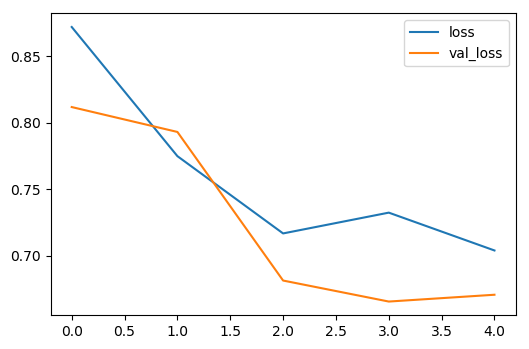

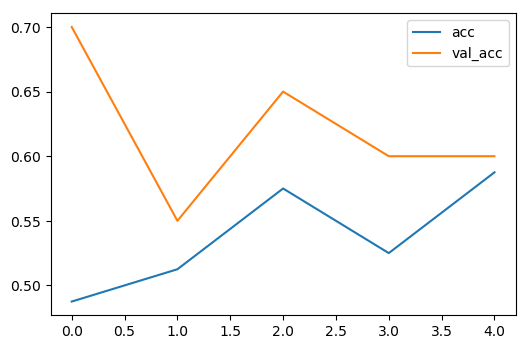

In [48]:
plt.figure(dpi=100)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.figure(dpi=100)
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [32]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [32]:

from ann_visualizer.visualize import ann_viz

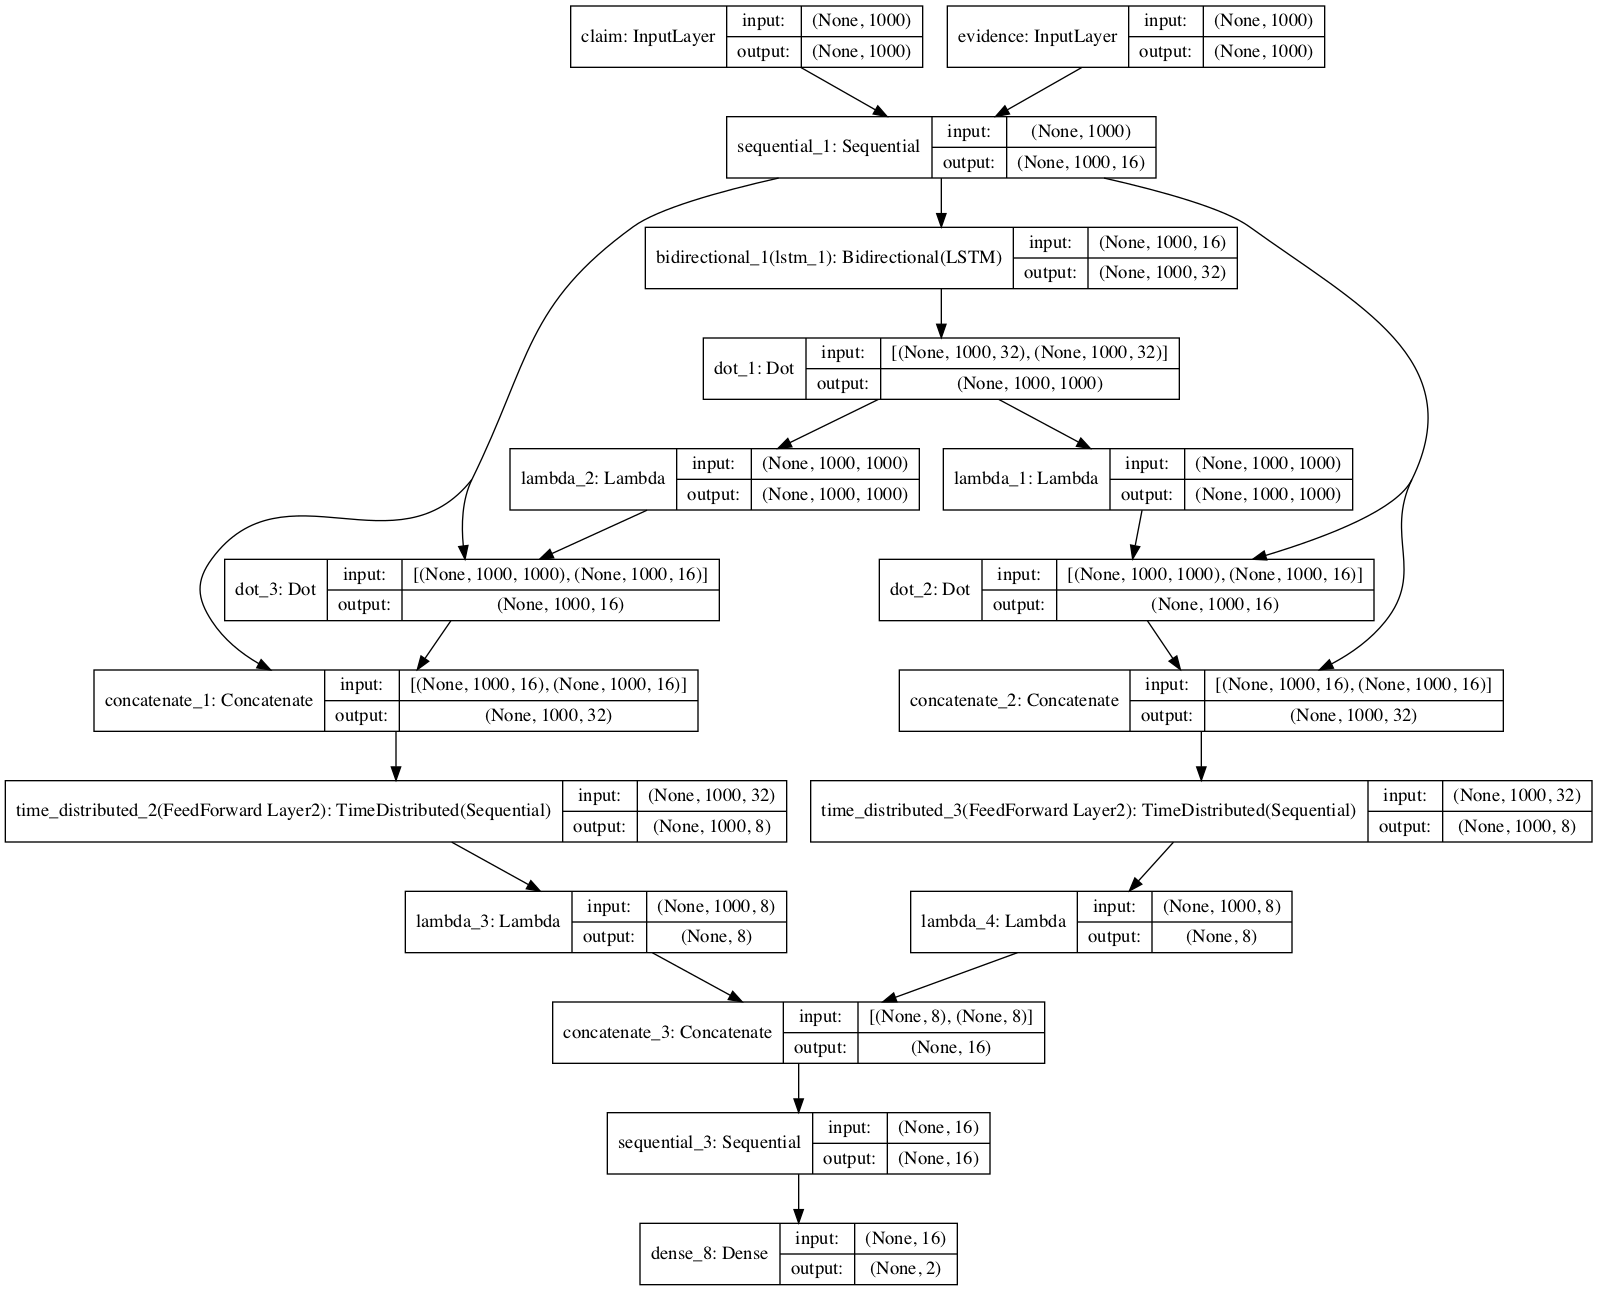

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [25]:
 df = pd.read_csv("_test_concated_features.csv")

In [26]:
df.head()

,Unnamed: 0,ID,claim,evidence,label,Jacards_Similarity,Keywords_Similarity,common_keywords,LCS
0,0,110000,Raven-Symoné is an Anglican.,Raven-Symoné Christina Pearman -LRB- -LSB- ˈre...,SUPPORTS,0.037037,0.331280,1,3
1,1,73397,Temple of the Dog celebrated the 37th annivers...,Temple of the Dog was an American rock band th...,SUPPORTS,0.058824,0.822379,4,9
2,2,16079,Solanum contains plants with ornamental flowers.,Solanum It also contains the nightshades and h...,SUPPORTS,0.444444,0.902835,4,4
3,3,114789,A Good Day to Die Hard is part of the Library ...,Die Hard with a Vengeance is a 1995 American a...,SUPPORTS,0.008696,0.827180,1,10
4,4,126871,The Icelandic Coast Guard is also known as Gae...,"Net cutters , or trawlwire cutters were secret...",SUPPORTS,0.010638,0.853973,1,9


In [27]:
test_claims = list(df["claim"])
test_evidences = list(df["evidence"])

In [28]:
test_X = create_dataset(nlp, test_claims, test_evidences,100,shape[0])

In [29]:
y_pred = model.predict(test_X,verbose=2)

In [30]:
y_classes = y_pred.argmax(axis=-1)

In [31]:
y_classes

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
y_labels = []
for item in y_classes:
    if item == 1:
        y_labels.append("SUPPORTS")
    else:
        y_labels.append("REFUTES")

In [33]:
df["label"] = y_labels

In [34]:
df["label"].value_counts()

SUPPORTS    10354
REFUTES      1765
Name: label, dtype: int64

In [35]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [36]:
df.to_csv("_test_concated_features.csv")